#Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-31 09:51:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-31 09:51:13 (30.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

##Becoming one with the data (PubMed 200k RCT)

Downloading dataset from: https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone "https://github.com/Franck-Dernoncourt/pubmed-rct"
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 31.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

###Preprocess data



In [ ]:
# Create function read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of a text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
test_lines = get_lines(data_dir+"test.txt")
dev_lines = get_lines(data_dir+"dev.txt")

### Let's think about how we want our data to look...
```
 [{'line_number': 0,
   "target": 'BACKGROUND',
   "text:": "Emotional eating is associated with overeating and the development of obesity .\n",
   "total_lines":11}]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if it is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line (\n)
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split  = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract?
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["target"] = target_text_split[0] # get target label
        abstract_samples.append(line_data) # append our line date dictionary to the list

    else: # the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 465 ms, sys: 246 ms, total: 711 ms
Wall time: 715 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:5]

[{'line_number': 0,
  'total_lines': 11,
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'target': 'OBJECTIVE'},
 {'line_number': 1,
  'total_lines': 11,
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'target': 'METHODS'},
 {'line_number': 2,
  'total_lines': 11,
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'target': 'METHODS'},
 {'line_number': 3,
  'total_lines': 11,
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'target': 'METHODS'},
 {'line_number': 4,
  'total_lines': 11,
  'text': 'secondary outcome measures included 

###Converting our list of dictionaries into a dataframe

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,line_number,total_lines,text,target
0,0,11,to investigate the efficacy of @ weeks of dail...,OBJECTIVE
1,1,11,a total of @ patients with primary knee oa wer...,METHODS
2,2,11,outcome measures included pain reduction and i...,METHODS
3,3,11,pain was assessed using the visual analog pain...,METHODS
4,4,11,secondary outcome measures included the wester...,METHODS


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

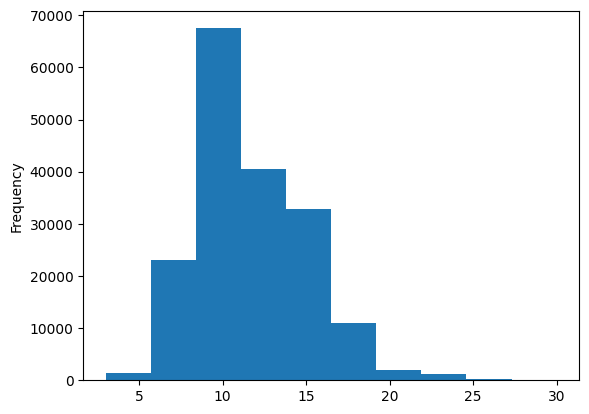

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

###Get lists of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

###Making numeric labels

In [ ]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

In [ ]:
# Label encode Labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Modelling Experiments

###`model_0`: Naive Bayes

In [ ]:
# Create a pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###`model_1`: Conv1D

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)

avg_sent_lens

26.338269273494777

####Text Vectorization

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)

avg_sent_len

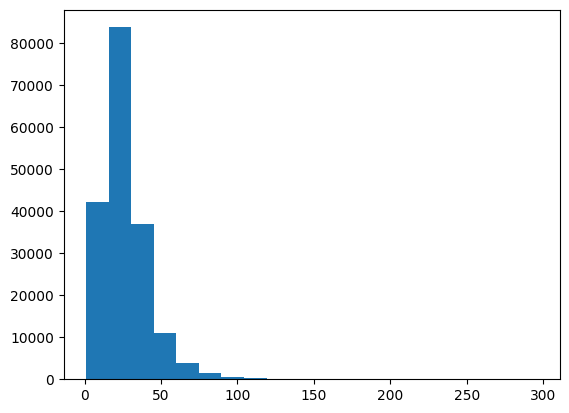

In [ ]:
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens) # one example has sentence length of 296

296

In [ ]:
# TextVectorization layer
text_vectorizer = layers.TextVectorization(
    max_tokens=68000,
    standardize="lower_and_strip_punctuation",
    output_mode='int',
    output_sequence_length=output_seq_len
)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
values are represented as average ( @ % ci ) .

Length of text: 46

Vectorized text: [[ 334   58 5483   25  405   50    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # different embedding sizes result in drastically differnet parameters to be trained
                               mask_zero=True, # use masking to handle variable sequence lengths
                               name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 values are represented as average ( @ % ci ) .

Sentence after vectorization:
 [[ 334   58 5483   25  405   50    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-2.8245544e-02  2.1193746e-02 -4.9621940e-02 ...  3.1479899e-02
   -1.5877329e-02  2.5070380e-02]
  [ 4.6848569e-02  3.0089859e-02 -1.7446496e-02 ... -2.8988469e-02
    2.4569426e-02 -8.6586364e-03]
  [ 3.3990476e-02 -4.7448348e-02 -3.2042153e-03 ...  9.3745701e-03
   -1.5415251e-05 -4.6009123e-02]
  ...
  [ 1.7137978e-02  4.8214529e-02 -1.5889168e-02 ... -3.4919977e-02
    3.6616359e-02 -2.1136452e-02]
  [ 1.7137978e-02  4.8214529e-02 -1.5889168e-02 ... -3.4919977e-02
    3.6616359e-02 -2.1136452e-02]
  [ 1.7137978e-02  4.8214529e-02 -1.5889168e-02 ... -3.4919977e-0

#### Creating datasets (making sure our data loads as fast as possible)

In [ ]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
len(train_dataset)

5627

In [ ]:
5627*32

180064

#### Building a Conv1D layer


In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_model_1 = model_1.fit(train_dataset,
                              epochs=3,
                              validation_data=val_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset))) # only validate 10% of batches

Epoch 1/3
562/562 [==============================] - 80s 140ms/step - loss: 0.9172 - accuracy: 0.6398 - val_loss: 0.6859 - val_accuracy: 0.7437
Epoch 2/3
562/562 [==============================] - 78s 138ms/step - loss: 0.6528 - accuracy: 0.7599 - val_loss: 0.6322 - val_accuracy: 0.7735
Epoch 3/3
562/562 [==============================] - 76s 136ms/step - loss: 0.6141 - accuracy: 0.7771 - val_loss: 0.5944 - val_accuracy: 0.7866


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5944 - accuracy: 0.7866


[0.5943791270256042, 0.7865749001502991]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:10], model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.4816887e-01, 1.6785662e-01, 6.8334319e-02, 2.9279819e-01,
         2.2841902e-02],
        [4.2560011e-01, 2.7760884e-01, 1.7473588e-02, 2.6786578e-01,
         1.1451567e-02],
        [1.5204667e-01, 6.3511669e-03, 1.5807601e-03, 8.3997148e-01,
         4.9953436e-05],
        [2.2017910e-05, 5.4666807e-04, 9.7869569e-01, 1.6458413e-05,
         2.0719282e-02],
        [1.3994855e-03, 4.5553640e-02, 3.4802255e-01, 9.1954676e-04,
         6.0410488e-01],
        [1.8635025e-02, 2.8886614e-02, 5.6341559e-01, 9.3214903e-03,
         3.7974128e-01],
        [5.6308275e-04, 4.6373284e-03, 2.4337409e-01, 2.6888202e-04,
         7.5115663e-01],
        [2.6848532e-02, 2.8256608e-02, 6.7592055e-01, 1.4879118e-02,
         2.5409529e-01],
        [8.3289110e-13, 2.4863024e-08, 8.4781057e-08, 1.8389112e-13,
         9.9999982e-01],
        [8.9474414e-03, 7.3689544e-01, 3.9534248e-02, 1.8071674e-02,
         1.9655120e-01]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.65748709122204,
 'precision': 0.7832600500324922,
 'recall': 0.7865748709122203,
 'f1': 0.7839218099215467}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###`model_2`: Feature Extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer('https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2',
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 between aug @ , and aug @ , @ , @ villages in rural honduras ( @-@ participants each ; total study population of @ ) received public health interventions .

Sentence after embedding:
 [ 0.0246615   0.07795911 -0.0714259  -0.00093036  0.00013887 -0.01227446
  0.0517736   0.03206728 -0.07018965  0.08054335  0.07078577  0.02007361
  0.03098127  0.05166966 -0.01183532  0.05807678 -0.06138259 -0.00115396
 -0.05086171 -0.03262908  0.06339213  0.02321535 -0.00279643  0.00037096
 -0.07422718  0.0052526   0.0358719  -0.0022158  -0.05157791 -0.01366821]

Length of sentence embedding: 512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_use_feature_extractor")

model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              validation_data=val_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 16ms/step - loss: 0.9187 - accuracy: 0.6476 - val_loss: 0.7981 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7709 - accuracy: 0.7012 - val_loss: 0.7572 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7547 - accuracy: 0.7114 - val_loss: 0.7435 - val_accuracy: 0.7101


In [ ]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7457 - accuracy: 0.7108


[0.7457472681999207, 0.7108103036880493]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 10s 11ms/step


array([[4.1872922e-01, 3.5839382e-01, 2.5753623e-03, 2.1293548e-01,
        7.3659620e-03],
       [3.3335778e-01, 5.2089167e-01, 4.1953209e-03, 1.3820127e-01,
        3.3539112e-03],
       [2.1259457e-01, 1.4953290e-01, 2.1290723e-02, 5.7764387e-01,
        3.8938027e-02],
       [1.2112186e-02, 5.1372722e-02, 8.1792086e-01, 8.7397983e-03,
        1.0985442e-01],
       [2.9006675e-02, 2.4941331e-01, 2.0891388e-01, 1.2777978e-02,
        4.9988818e-01],
       [9.1560103e-04, 2.5084238e-03, 6.9607645e-01, 1.3845931e-04,
        3.0036095e-01],
       [1.9517754e-03, 3.7971835e-03, 6.4355332e-01, 1.2709581e-03,
        3.4942669e-01],
       [4.1121813e-03, 2.2722859e-02, 4.9294344e-01, 1.0658138e-03,
        4.7915578e-01],
       [6.2871777e-04, 8.7485621e-03, 2.3272494e-02, 1.0685500e-03,
        9.6628165e-01],
       [1.2609802e-01, 6.9057018e-01, 2.6736364e-02, 8.7347947e-02,
        6.9247559e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 71.08102740632862,
 'precision': 0.7116387482880675,
 'recall': 0.7108102740632861,
 'f1': 0.7075461216057027}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

###`model_3`: Conv1D with character embeddings

Previously, we build token level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

####Creating a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [ ]:
split_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[:3]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# What's the average character length?
char_lens = [len(character) for character in train_sentences]
avg_char_len = np.mean(char_lens)

int(avg_char_len)

149

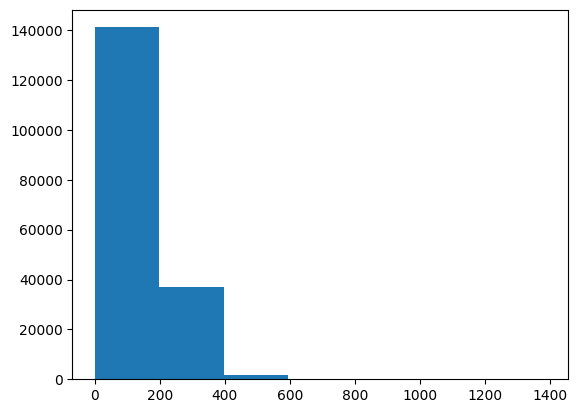

In [ ]:
# Check the distribution of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
keyboard_chars = string.ascii_lowercase + string.digits + string.punctuation
keyboard_chars

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level vectorizer instance
NUM_CHAR_TOKENS = len(keyboard_chars) + 2 # OOV + space
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars)}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}\n")
print(f"Length of vectorized chars:\n {len(vectorized_chars[0])}")

Charified text:
 m e a n   l e v e l s   o f   i l - @   a n d   i l - @   i n   t h e   n o r m a l   g r o u p   w e r e   l o w e r   t h a n   i n   c h d   p a t i e n t s   .

Length of random_train_chars: 163

Vectorized chars:
 [[15  2  5  6 12  2 21  2 12  9  7 17  4 12  5  6 10  4 12  4  6  3 13  2
   6  7  8 15  5 12 18  8  7 16 14 20  2  8  2 12  7 20  2  8  3 13  5  6
   4  6 11 13 10 14  5  3  4  2  6  3  9  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  

####Creating a character-level embeddding

In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="character_embedding")

char_embed

In [ ]:
# Test out the character-level embedding
random_train_chars = random.choice(train_chars)
print(f"Charified Text:\n{random_train_chars}\n")
print(f"Length of Charified Text: {len(random_train_chars)}\n")
print(f"Charified Text after vectorization:\n{char_vectorizer([random_train_chars])}\n")
print(f"Length after vectorization: {len(char_vectorizer([random_train_chars])[0])}\n")
print(f"Charified Text after embedding:\n{char_embed(char_vectorizer([random_train_chars]))}\n")
print(f"Shape after embedding: {char_embed(char_vectorizer([random_train_chars])).shape}")

Charified Text:
a d v a n c e d   n e o p l a s m s   w e r e   d e t e c t e d   i n   @   s u b j e c t s   (   @   %   )   i n   t h e   s i g m o i d o s c o p y   s i m u l a t i o n   g r o u p   c o m p a r e d   w i t h   @   (   @   %   )   i n   t h e   f i t   g r o u p   (   o d d s   r a t i o   f o r   s i g m o i d o s c o p y   ,   @   ;   @   %   c o n f i d e n c e   i n t e r v a l   ,   @ - @   @   ;   p   =   @   )   .

Length of Charified Text: 427

Charified Text after vectorization:
[[ 5 10 21  5  6 11  2 10  6  2  7 14 12  5  9 15  9 20  2  8  2 10  2  3
   2 11  3  2 10  4  6  9 16 22 27  2 11  3  9  4  6  3 13  2  9  4 18 15
   7  4 10  7  9 11  7 14 19  9  4 15 16 12  5  3  4  7  6 18  8  7 16 14
  11  7 15 14  5  8  2 10 20  4  3 13  4  6  3 13  2 17  4  3 18  8  7 16
  14  7 10 10  9  8  5  3  4  7 17  7  8  9  4 18 15  7  4 10  7  9 11  7
  14 19 11  7  6 17  4 10  2  6 11  2  4  6  3  2  8 21  5 12 14  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0 

####Building a Conv1D with character embeddings

In [ ]:
# Create datasets for character-level embeddings
train_dataset_chars = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_dataset_chars = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_dataset_chars = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

train_dataset_chars

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Convert TensorFlowSliceDatasets into Prefetched datasets
train_dataset_chars = train_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_chars = val_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_chars = test_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_chars

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make Conv1D on characters only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectorization = char_vectorizer(inputs)
char_embedding = char_embed(char_vectorization)
x = layers.Conv1D(filters=64, kernel_size=7, strides=1, padding="same", activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1d_with_character_tokenization_and_embedding")

model_3.compile(loss="categorical_crossentropy",
                optimizer='Adam',
                metrics=["accuracy"])

history_model_3 = model_3.fit(train_dataset_chars,
                              epochs=3,
                              validation_data=val_dataset_chars,
                              steps_per_epoch=int(0.1*len(train_dataset_chars)),
                              validation_steps=int(0.1*len(val_dataset_chars)))


Epoch 1/3
562/562 [==============================] - 15s 26ms/step - loss: 1.2273 - accuracy: 0.5062 - val_loss: 1.0116 - val_accuracy: 0.6117
Epoch 2/3
562/562 [==============================] - 15s 26ms/step - loss: 0.9622 - accuracy: 0.6190 - val_loss: 0.8956 - val_accuracy: 0.6523
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 0.8824 - accuracy: 0.6556 - val_loss: 0.8187 - val_accuracy: 0.6892


In [ ]:
# Evaluate model_3
model_3.evaluate(val_dataset_chars)

945/945 [==============================] - 7s 8ms/step - loss: 0.8416 - accuracy: 0.6756


[0.8416499495506287, 0.6756255626678467]

In [ ]:
# Make predictions on model_3
model_3_pred_probs = model_3.predict(val_chars)
model_3_pred_probs[:10]

945/945 [==============================] - 7s 7ms/step


array([[1.1439107e-01, 4.5809397e-01, 2.0986269e-01, 1.4521790e-01,
        7.2434470e-02],
       [3.8794354e-01, 2.5621390e-01, 3.7834402e-02, 2.8068864e-01,
        3.7319552e-02],
       [1.8554294e-01, 2.6094252e-01, 1.3868193e-01, 3.4721112e-01,
        6.7621447e-02],
       [1.5597356e-02, 3.0931089e-02, 8.5214239e-01, 1.2210497e-02,
        8.9118585e-02],
       [6.2074163e-03, 5.5863064e-02, 6.9119388e-01, 8.1252512e-03,
        2.3861048e-01],
       [1.5873360e-04, 4.0141435e-04, 6.6515911e-01, 7.3196738e-05,
        3.3420759e-01],
       [5.5589643e-03, 1.5012278e-02, 4.5021102e-01, 2.6233308e-03,
        5.2659434e-01],
       [2.5615212e-01, 2.5647065e-01, 6.6333406e-02, 2.1084167e-01,
        2.1020220e-01],
       [2.2890053e-03, 9.9955751e-03, 7.0249870e-02, 3.5387883e-03,
        9.1392672e-01],
       [1.0441905e-01, 3.5785466e-01, 7.9601862e-02, 2.3952687e-01,
        2.1859758e-01]], dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 0, 3, 2, 2, 2, 4, 1, 4, 1])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 67.56255792400371,
 'precision': 0.6706516538605255,
 'recall': 0.6756255792400371,
 'f1': 0.6672480085774485}

###`model_4`: Pretrained token embeddding + character embedding

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenate layer
4. Build a series of output layers on top of 3
5. Construct a model which takes character-level and token sequences as inputs and produces the sequence label probabilities as output

In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Setup char-level inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layer=layers.LSTM(units=24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_model")

# 3. Concatenate token  and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout layer
combined_dropout = layers.Dropout(rate=0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(rate=0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with character and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_hybrid_embeddings")

In [ ]:
# Compiling model_4
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
# Summary of model_4
model_4.summary()

Model: "model_4_hybrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['toke

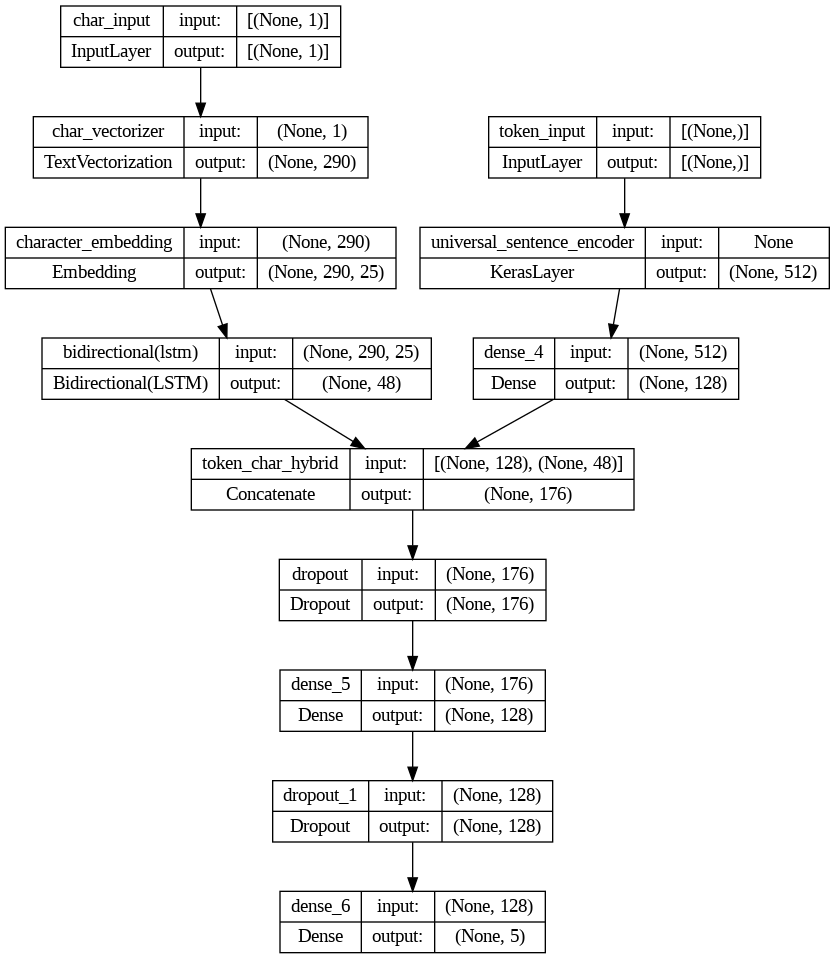

In [ ]:
# Plot hybrid token and character model
plot_model(model_4, show_shapes=True)

####Combining token and character data into a `tf.data.Dataset`

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model_4 on tokens and characters
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 175s 293ms/step - loss: 0.9833 - accuracy: 0.6052 - val_loss: 0.7733 - val_accuracy: 0.7008
Epoch 2/3
562/562 [==============================] - 153s 272ms/step - loss: 0.8011 - accuracy: 0.6894 - val_loss: 0.7114 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 177s 315ms/step - loss: 0.7695 - accuracy: 0.7080 - val_loss: 0.6893 - val_accuracy: 0.7450


In [ ]:
# Evaluate model_4
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 99s 105ms/step - loss: 0.6943 - accuracy: 0.7356


[0.6943014860153198, 0.7356017231941223]

In [ ]:
# Make predictions on model_4
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs[:10]

945/945 [==============================] - 91s 93ms/step


array([[4.8323861e-01, 2.8204522e-01, 3.7216109e-03, 2.2598660e-01,
        5.0079892e-03],
       [3.4208468e-01, 4.5502350e-01, 3.1999853e-03, 1.9800586e-01,
        1.6859457e-03],
       [3.0482736e-01, 1.4402920e-01, 4.7764573e-02, 4.7423387e-01,
        2.9144902e-02],
       [1.1477557e-02, 1.8845135e-02, 8.3381242e-01, 6.5635634e-03,
        1.2930135e-01],
       [2.9338408e-02, 9.0871096e-02, 6.5257800e-01, 1.2671406e-02,
        2.1454120e-01],
       [4.2855088e-04, 2.2133042e-03, 6.8097377e-01, 1.5174919e-04,
        3.1623268e-01],
       [2.1419327e-03, 1.0295772e-02, 5.5208814e-01, 1.1832933e-03,
        4.3429083e-01],
       [3.1718367e-03, 2.0760978e-02, 4.4725558e-01, 1.0322307e-03,
        5.2777934e-01],
       [6.2306970e-04, 8.5190665e-03, 3.5091136e-02, 2.1276918e-04,
        9.5555401e-01],
       [3.3274040e-01, 4.3504718e-01, 3.0873185e-02, 1.5499714e-01,
        4.6341997e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 2, 2, 2, 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

model_4_results

{'accuracy': 73.56017476499404,
 'precision': 0.7368808255501476,
 'recall': 0.7356017476499405,
 'f1': 0.7342067697921608}

###`model_5`: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,line_number,total_lines,text,target
0,0,11,to investigate the efficacy of @ weeks of dail...,OBJECTIVE
1,1,11,a total of @ patients with primary knee oa wer...,METHODS
2,2,11,outcome measures included pain reduction and i...,METHODS
3,3,11,pain was assessed using the visual analog pain...,METHODS
4,4,11,secondary outcome measures included the wester...,METHODS


>**Note**: Any engineered features used to train a model need to be available at test time. In this case, line numbers and total lines are available.

####Create positional embeddings

In [ ]:
# How many different lines numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

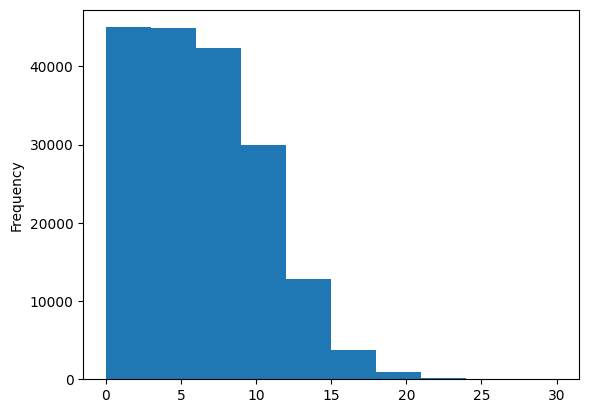

In [ ]:
# Check the distribution of "line_number" feature
train_df["line_number"].plot.hist();

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of "line_number" feature
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

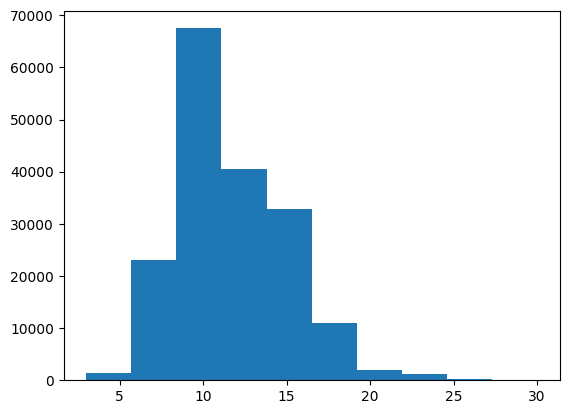

In [ ]:
plt.hist(train_df["total_lines"]);

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

####Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the `line_number` feature
4. Create a model for the `total_lines` feature
5. Combine the outputs of 1 and 2 using `tf.keras.layers.Concatenate`
6. Combine the outputs of 3, 4 and 5 using `tf.keras.layers.Concatenate`
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name="token_inputs_model")

# 2. Character-level inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(units=24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm, name="char_inputs_model")

# 3. Line numbers model
line_numbers_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
line_numbers_embedding = layers.Dense(32, activation="relu")(line_numbers_inputs)
line_numbers_model = tf.keras.Model(line_numbers_inputs, line_numbers_embedding, name="line_numbers_inputs_model")

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_embedding = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_embedding, name="total_lines_inputs_model")

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_and_token_hybrid_embedding")([token_model.output,
                                                                                  char_model.output])
combined_embeddings_dense = layers.Dense(256, activation="relu")(combined_embeddings)
combined_embeddings_dropout = layers.Dropout(rate=0.5)(combined_embeddings_dense)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_numbers_model.output,
                                                                                 total_lines_model.output,
                                                                                 combined_embeddings_dropout])
tribrid_embeddings_dense = layers.Dense(128, activation="relu")(tribrid_embeddings)
tribrid_embeddings_dropout = layers.Dropout(rate=0.15)(tribrid_embeddings_dense)

# 7. Create an output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings_dropout)

# 8. Put together the model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[token_model.inputs,
                                 char_model.inputs,
                                 line_numbers_model.inputs,
                                 total_lines_model.inputs],
                         outputs=output_layer,
                         name="model_5_tribrid_embeddings")

In [ ]:
# Get summmary of tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['tok

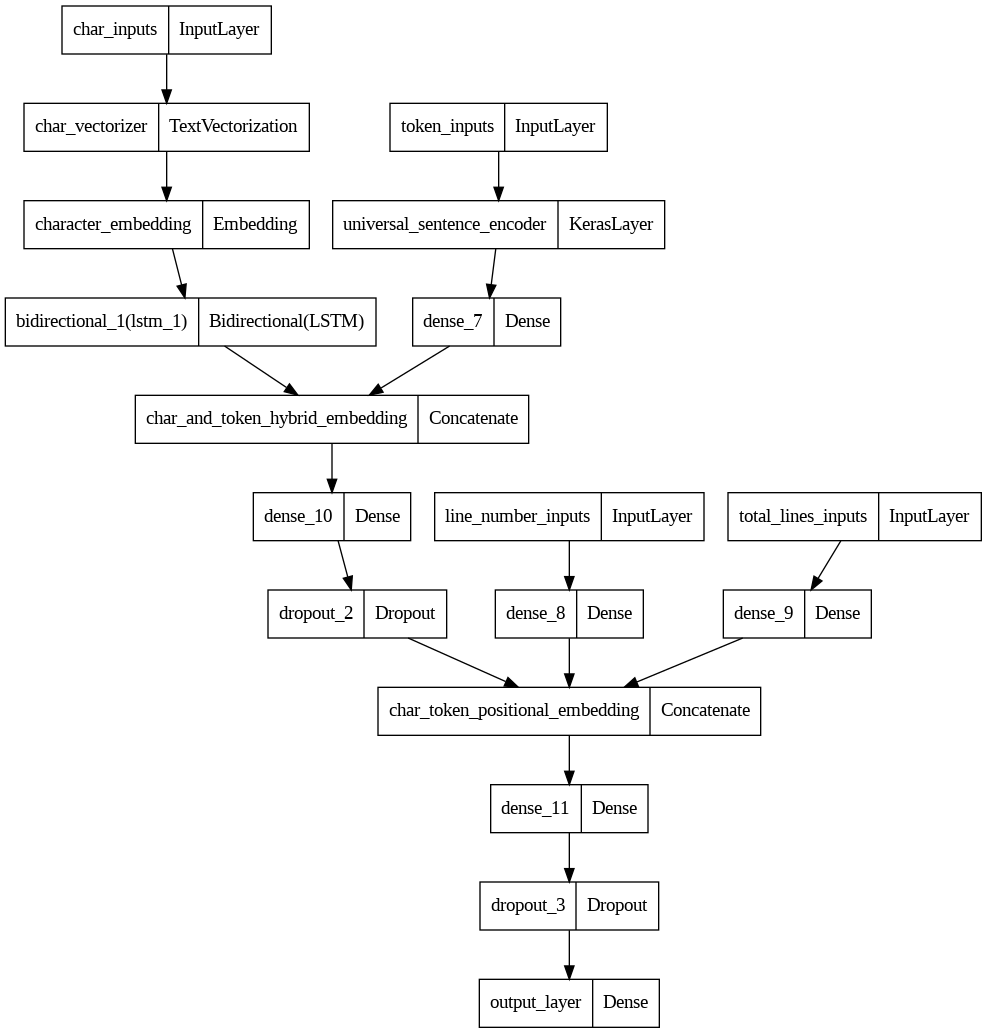

In [ ]:
# Plot the model_5
plot_model(model_5)

>**Label smoothing:**
>for example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

>>Really confident: [0.0, 0.0, 1.0, 0.0, 0.0]

>What label smoothing does is that it assigns some of the value from the highest prediction probability to other classes, in turn, hopefully improving generalization...

>>After label smoothing: [0.01, 0.01, 0.96, 0.01, 0.01]



In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

####Creating datasets with `tf.data.Dataset`

In [ ]:
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels))

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels))

test_tribrid_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_numbers_one_hot, test_total_lines_one_hot))
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip((test_tribrid_data, test_tribrid_labels))

# Prefetch the datasets
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_tribrid_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

####Fitting, evaluating and making predictions on tribrid model

In [ ]:
# Fit model_5
history_model_5 = model_5.fit(train_tribrid_dataset,
                    epochs=3,
                    validation_data=val_tribrid_dataset,
                    steps_per_epoch=int(0.1*len(train_tribrid_dataset)),
                    validation_steps=int(0.1*len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 187s 314ms/step - loss: 1.0546 - accuracy: 0.7483 - val_loss: 0.9427 - val_accuracy: 0.8251
Epoch 2/3
562/562 [==============================] - 179s 319ms/step - loss: 0.9389 - accuracy: 0.8266 - val_loss: 0.9112 - val_accuracy: 0.8431
Epoch 3/3
562/562 [==============================] - 229s 408ms/step - loss: 0.9184 - accuracy: 0.8374 - val_loss: 0.8926 - val_accuracy: 0.8501


In [ ]:
# Evaluate model_5
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 84s 88ms/step - loss: 0.8929 - accuracy: 0.8522


[0.8928616046905518, 0.8522441387176514]

In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred_probs[:5]

945/945 [==============================] - 64s 63ms/step


array([[0.49272698, 0.04994365, 0.02606363, 0.39795446, 0.03331124],
       [0.57750744, 0.03167677, 0.03102407, 0.33130914, 0.02848269],
       [0.3106537 , 0.04723153, 0.07363404, 0.49885884, 0.06962182],
       [0.04340585, 0.04371579, 0.7808341 , 0.04199564, 0.09004862],
       [0.04848014, 0.04928314, 0.7300705 , 0.04815472, 0.12401157]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results

{'accuracy': 85.22441414007679,
 'precision': 0.8524194270834557,
 'recall': 0.8522441414007679,
 'f1': 0.8508881780330566}

###Comparing models results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.657487,0.783260,0.786575,0.783922
model_2_pretrained_token_embedding,71.081027,0.711639,0.710810,0.707546
model_3_custom_char_embedding,67.562558,0.670652,0.675626,0.667248
model_4_hybrid_char_token_embedding,73.560175,0.736881,0.735602,0.734207
model_5_pos_char_token_embedding,85.224414,0.852419,0.852244,0.850888


In [ ]:
# Normalize the accuracies
all_model_results["accuracy"] /= 100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.786575,0.783260,0.786575,0.783922
model_2_pretrained_token_embedding,0.710810,0.711639,0.710810,0.707546
model_3_custom_char_embedding,0.675626,0.670652,0.675626,0.667248
model_4_hybrid_char_token_embedding,0.735602,0.736881,0.735602,0.734207
model_5_pos_char_token_embedding,0.852244,0.852419,0.852244,0.850888


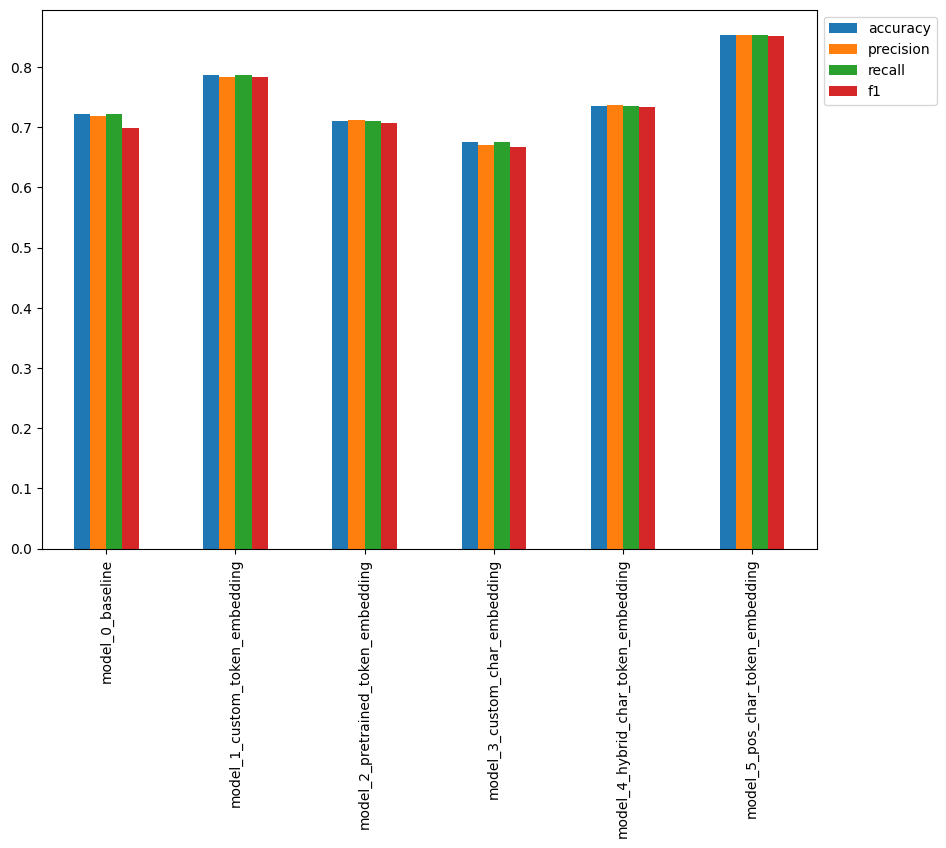

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

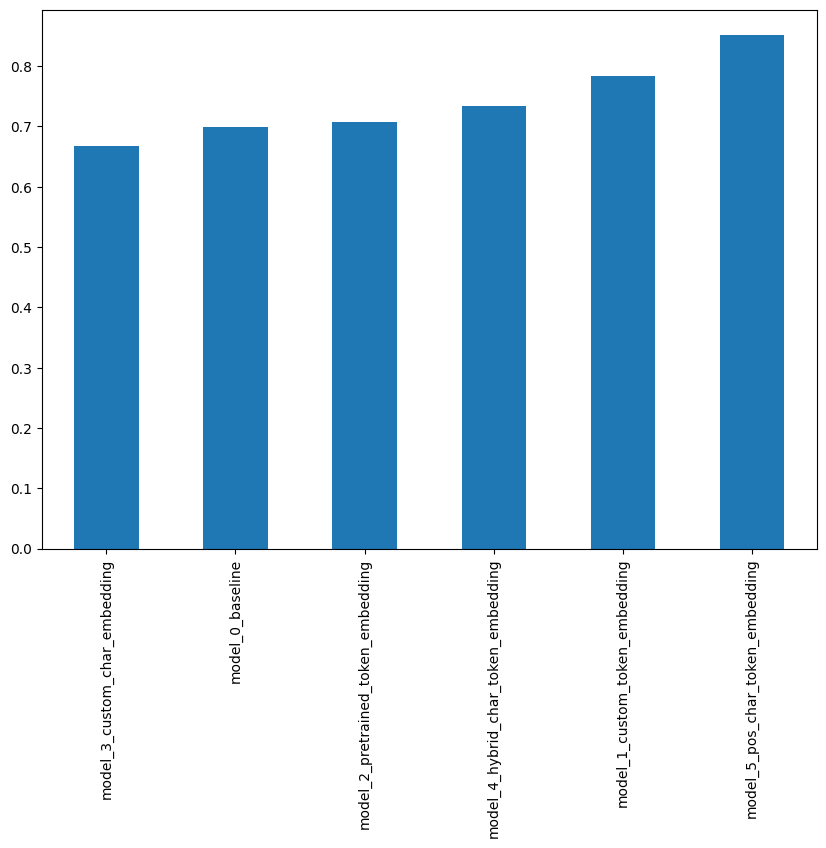

In [ ]:
# Sort the model results by f1-score
all_model_results.sort_values(by="f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

##Save and Load model

In [ ]:
# Save the best performing model to SvaedModel format (default)
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in the best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# Make predictions with the loaded model on Valisation data
loaded_pred_probs = loaded_model.predict(val_tribrid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 63s 63ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)

loaded_model_results

{'accuracy': 85.22441414007679,
 'precision': 0.8524194270834557,
 'recall': 0.8522441414007679,
 'f1': 0.8508881780330566}

In [ ]:
assert model_5_results == loaded_model_results # this would error out if results were not equal

In [ ]:
# Check loaded model summary()
loaded_model.summary()

Model: "model_5_tribrid_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['tok

##Making predictions on Testing data

In [ ]:
testing_pred_probs = model_5.predict(test_tribrid_dataset) # or loaded_model.predict(test_tribrid_dataset)
testing_pred_probs[:10]

942/942 [==============================] - 61s 65ms/step


array([[0.34178615, 0.0540486 , 0.03904599, 0.5248088 , 0.04031047],
       [0.4126779 , 0.04067909, 0.13499928, 0.36959964, 0.04204405],
       [0.04368621, 0.0371124 , 0.7985937 , 0.07010046, 0.05050732],
       [0.04028782, 0.03664942, 0.77700806, 0.04525544, 0.10079928],
       [0.04305137, 0.04496101, 0.12315174, 0.04260812, 0.74622774],
       [0.03374884, 0.03058306, 0.03671072, 0.03409739, 0.86486006],
       [0.03456092, 0.12102798, 0.1773643 , 0.04343273, 0.623614  ],
       [0.06493329, 0.5660666 , 0.13841362, 0.04722538, 0.18336104],
       [0.02309693, 0.6710129 , 0.024438  , 0.03462513, 0.24682707],
       [0.59794074, 0.03309778, 0.03077351, 0.31189898, 0.02628911]],
      dtype=float32)

In [ ]:
testing_preds = tf.argmax(testing_pred_probs, axis=1)
testing_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
test_labels_encoded[:10] == testing_preds[:10]

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([False, False, False, False,  True,  True,  True,  True,  True,
        True])>

In [ ]:
testing_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=testing_preds)

testing_results

{'accuracy': 84.67230794756927,
 'precision': 0.8463059236051067,
 'recall': 0.8467230794756927,
 'f1': 0.8452943527567055}